## Parallelization in Langgraph

**Parallelization** allows multiple nodes to execute simultaneously, improving efficiency when tasks are independent of each other.

### Why Use Parallelization?
- **Speed**: Run independent tasks at the same time
- **Efficiency**: Utilize resources better
- **Scalability**: Handle multiple operations concurrently

### Example Scenario
When analyzing a topic, you might want to:
1. Generate a summary
2. Extract key points
3. Create a title

These tasks are **independent** - they don't need each other's output. Running them in parallel saves time!

In [1]:
import os
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from dotenv import load_dotenv

load_dotenv()
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL")

# Initialize the LLM
llm = ChatOllama(model="glm-5:cloud", base_url=OLLAMA_BASE_URL)

In [2]:
from operator import add
from typing import List

# Define the State - note the use of 'add' reducer for parallel results
class State(TypedDict):
    topic: str                    # Input: the topic to analyze
    summary: str                  # Output from summarize node
    key_points: List[str]         # Output from extract node
    title: str                    # Output from title node

In [3]:
# Node 1: Generate a summary
def summarize(state: State) -> dict:
    prompt = f"Write a brief 2-sentence summary about: {state['topic']}"
    response = llm.invoke(prompt)
    return {"summary": response.content}

# Node 2: Extract key points
def extract_points(state: State) -> dict:
    prompt = f"List 3 key points about: {state['topic']}. Format as a simple list."
    response = llm.invoke(prompt)
    # Split into list items
    points = [p.strip() for p in response.content.split('\n') if p.strip()]
    return {"key_points": points}

# Node 3: Generate a title
def generate_title(state: State) -> dict:
    prompt = f"Create a catchy title for an article about: {state['topic']}. Just the title, nothing else."
    response = llm.invoke(prompt)
    return {"title": response.content}

In [4]:
# Build the graph with parallel execution
graph_builder = StateGraph(State)

# Add all nodes
graph_builder.add_node("summarize", summarize)
graph_builder.add_node("extract_points", extract_points)
graph_builder.add_node("generate_title", generate_title)

# Parallel edges: START connects to ALL three nodes simultaneously
graph_builder.add_edge(START, "summarize")
graph_builder.add_edge(START, "extract_points")
graph_builder.add_edge(START, "generate_title")

# All three nodes connect to END
graph_builder.add_edge("summarize", END)
graph_builder.add_edge("extract_points", END)
graph_builder.add_edge("generate_title", END)

# Compile the graph
graph = graph_builder.compile()

In [5]:
# Run the parallel graph
result = graph.invoke({"topic": "Artificial Intelligence"})

# Display results
print("=" * 50)
print("PARALLEL EXECUTION RESULTS")
print("=" * 50)

print("\n📝 TITLE:")
print(result.get("title", "No title generated"))

print("\n📄 SUMMARY:")
print(result.get("summary", "No summary generated"))

print("\n🔑 KEY POINTS:")
for i, point in enumerate(result.get("key_points", []), 1):
    print(f"  {i}. {point}")

PARALLEL EXECUTION RESULTS

📝 TITLE:
Rise of the Machines: How Artificial Intelligence is Rewriting the Rules of Reality

📄 SUMMARY:
Artificial Intelligence is the simulation of human intelligence by computer systems, enabling them to perform tasks like learning, reasoning, and problem-solving. This transformative technology is reshaping industries globally by automating complex processes and generating insights from vast amounts of data.

🔑 KEY POINTS:
  1. 1.  **Simulation of Human Intelligence:** AI involves computer systems designed to mimic cognitive functions such as learning, reasoning, problem-solving, and perception.
  2. 2.  **Data-Driven Learning:** Through techniques like machine learning, AI systems analyze vast amounts of data to recognize patterns and improve their performance without being explicitly programmed for every specific task.
  3. 3.  **Broad Impact and Ethics:** AI drives innovation across numerous industries, from healthcare to finance, but it also raises si

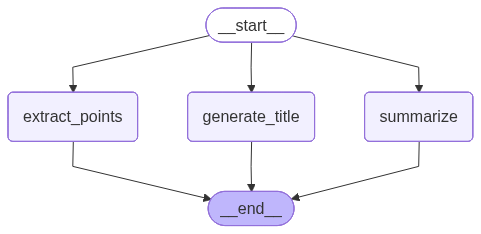

In [6]:
# Visualize the parallel graph structure
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph visualization requires additional dependencies")
    print("")
    print("Parallel Flow:")
    print("         ┌── summarize ───┐")
    print("    START├── extract_points├── END")
    print("         └── generate_title┘")

### How Parallelization Works

**Key Points:**
1. **Multiple edges from START** - All nodes connected to START run simultaneously
2. **Independent execution** - Each node processes the same input state independently
3. **State merging** - Results from all parallel nodes are merged into the final state

**When to Use Parallelization:**
- Tasks don't depend on each other's output
- You want to reduce total execution time
- Multiple perspectives on the same data (e.g., sentiment analysis + keyword extraction)

**Important Note:**
LangGraph handles the synchronization automatically - the graph waits for all parallel nodes to complete before proceeding to END.